# Estimating Cumulative Periodic Rewards (CPR) using Least Squares

In order to evaluate a policy, algorithms such as n-step SARSA and Monte Carlo rely on rewards being available for every action.
In this notebook, we explore the problem of cumulative periodic rewards - rewards that are made avaiable every K steps, and represent an aggreate over the rewards of the last previous steps.

We investigate the method of Least Squares to estimate the true rewards of state action pairs.

In [1]:
import pathlib
import os
import os.path
import json
import getpass
import glob
from typing import Any, Callable, Sequence, Mapping, Text, Union, Tuple
import copy
import itertools

import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import logging

## Data

  - Problem ABC
  - Difficulty: 3 letters (4 states, 4 actions)
  - Reward Period: 2 (every 2 steps)


In [2]:
%matplotlib inline

In [3]:
LOGS = pathlib.Path(f"/Users/{getpass.getuser()}/fs/abc/trajectory/L03/1621248247/1621248252")

In [4]:
def log_files(path: pathlib.Path):
    return glob.glob(str(os.path.join(path, "partition-*.json")))

In [5]:
def load_logs_as_dataset(path: pathlib.Path):
    files = log_files(path)
    traj = []
    for filename in files:
        with open(filename, "r") as reader:
            for line in reader:
                traj.append(json.loads(line))
    return traj

In [6]:
logs = load_logs_as_dataset(LOGS)

In [7]:
len(logs)

3860

In [8]:
def state_id(observation: np.ndarray) -> int:
    """
    Each letter can be a zero or one.
    They can only be learned in order.
    There is one dummy value of one in the observation.
    For two letters:
        [1, 0, 0] = 0 (starting state)
        [1, 1, 0] = 1
        [1, 1, 1] = 2
    """
    return np.sum(observation) - 1

## Data Validity Completeness


First, let's check if our data vaoid sub-trajectories - because we use TFUniformReplayBuffer, it's does a best effort at ensuring transitions are sampled in order, but there is no guarantee.

In [9]:
# use permutations
# remove any where i > j - we only need one value per combination, because 

In [10]:
def is_valid_tensition(transitions: Tuple[Tuple, Tuple], num_letters: int) -> Sequence[Tuple[Tuple, Tuple]]:
    """
    Generates a sequence of possible transitions
    """
    for i in range(len(transitions) - 1):
        begin_state, begin_action = transitions[i]
        end_state, _ = transitions[i+1]
        if begin_state > end_state:
            return False
        if end_state - begin_state > 1:
            return False
        if end_state - begin_state == 1 and begin_state != begin_action:
            return False
    return True

In [11]:
def validity_check(logs: Sequence[Any], num_letters: int) -> bool:
    invalid = set()
    invalid_count = 0
    
    for traj in logs:
        # assumed to be 2
        steps = len(traj['step_type'])
        transitions = []
        for step in range(steps):
            state = state_id(traj['observation'][step])
            action = traj['action'][step]
            transitions.append((state, action))
        transitions = tuple(transitions)
        if not is_valid_tensition(transitions, num_letters):
            invalid.add(transitions)
            invalid_count += 1
    return invalid_count > 1, {"invalid": {"unique":  invalid, "count": invalid_count}}

In [12]:
has_invalid, invalid_info = validity_check(logs, num_letters=7)

In [13]:
has_invalid

True

In [14]:
list(invalid_info["invalid"]["unique"])[:10]

[((2, 1), (3, 1)),
 ((0, 1), (1, 0)),
 ((2, 1), (3, 3)),
 ((0, 3), (1, 0)),
 ((0, 3), (1, 1)),
 ((0, 2), (1, 2)),
 ((2, 3), (3, 1)),
 ((1, 0), (2, 0)),
 ((0, 2), (1, 3)),
 ((2, 1), (3, 2))]

In [15]:
invalid_info["invalid"]["count"] / len(logs)

0.1966321243523316

## Processing: Representation

To solve the problem of estimating cumulative periodic rewards, we'll transform the data into a matrix format that allows us to solve the problem using least squares.

Three such representations are explored:

1. Presence: $(S_{1},A_{1}), (S_{1}, A_{2}),..(S_{2}, A_{1}),..(S_{n}, A_{n})$ -> in this format, we use a 1 to flag (state, action) pairs present in the sub-sequence and 0 for states that are absent

2. Occurence: $(S_{1},A_{1}), (S_{1}, A_{2}),..(S_{2}, A_{1}),..(S_{n}, A_{n})$ -> in this format, we use the number of states each (state, action) pair appears in the sub-sequence

3. Both: $(S_{1},A_{1})^{p}, (S_{1}, A_{1})^{o},..(S_{2}, A_{1})^{p}, (S_{2}, A_{1})^{o},..(S_{n}, A_{n})^{p}, (S_{n}, A_{n})^{o}$ -> in this format, we use two factors per (state, action) pair; one to indicate presence, and the other occurence.

In [16]:
def preprocessing(logs: Sequence[Mapping[Text, Any]], op: Callable[[Any], Any]):
    factors, result = [], []
    for log in logs:
        row, y = op(log)
        factors.append(row)
        result.append(y)
    return tf.convert_to_tensor(factors, tf.float32), tf.convert_to_tensor(result, tf.float32)
    

In [17]:
logs[1]

{'step_type': [1, 1],
 'observation': [[1, 0, 0, 0], [1, 0, 0, 0]],
 'action': [1, 3],
 'policy_info': {'log_probability': [-1.3862943649291992,
   -1.3862943649291992]},
 'next_step_type': [1, 1],
 'reward': [-1.0, -3.0],
 'discount': [1.0, 1.0]}

In [18]:
def create_presence_transform_op(num_states: int, num_actions: int):
    def op(record: Mapping[Text, Any]) -> Tuple[Any, Any]:
        row = np.zeros(shape=(num_states, num_actions))
        steps = len(record['step_type'])
        cpr = sum(record['reward'])
        for step in range(steps):
            state = state_id(record['observation'][step])
            action = record['action'][step]
            row[state, action] = 1
        return row.flatten(), cpr
    return op
            

In [19]:
create_presence_transform_op(4, 4)(logs[1])

(array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), -4.0)

In [20]:
def create_occurence_transform_op(num_states: int, num_actions: int):
    def op(record: Mapping[Text, Any]) -> Tuple[Any, Any]:
        row = np.zeros(shape=(num_states, num_actions))
        steps = len(record['step_type'])
        cpr = sum(record['reward'])
        for step in range(steps):
            state = state_id(record['observation'][step])
            action = record['action'][step]
            row[state, action] += 1
        return row.flatten(), cpr
    return op
            

In [21]:
create_occurence_transform_op(4, 4)(logs[1])

(array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), -4.0)

In [22]:
def create_presence_and_occurence_transform_op(num_states: int, num_actions: int):
    def op(record: Mapping[Text, Any]) -> Tuple[Any, Any]:
        presence = np.zeros(shape=(num_states, num_actions))
        occurrence = np.zeros(shape=(num_states, num_actions))
        steps = len(record['step_type'])
        cpr = sum(record['reward'])
        for step in range(steps):
            state = state_id(record['observation'][step])
            action = record['action'][step]
            presence[state, action] = 1
            occurrence[state, action] += 1
        return np.concatenate((presence, occurrence), axis=1).flatten(), cpr
    return op

In [23]:
create_presence_and_occurence_transform_op(4, 4)(logs[1])

(array([0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 -4.0)

## Least Squares Estimation

In [24]:
def solve_least_squares(
    matrix: Union[tf.Tensor, np.ndarray],
    rhs: Union[tf.Tensor, np.ndarray],
    l2_regularizer: float = 0.5,
) -> tf.Tensor:
    """
    Computes the solution to n variables using Least-Squares.

    Args:
        matrix: A 2D tensor, A, shaped m x n.
        rhs: A set of outcomes, b, shaped m.
        l2_regularizer: A regularization factor.

    Returns:
        The solution x to the least-squares problem Ax=b, shaped n.
    """
    shape = tf.shape(matrix)
    if tf.size(shape) != 2:
        raise ValueError(f"Only 2D tensors are supported. Got shape: {shape}")

    matrix = tf.expand_dims(matrix, axis=0)
    rhs = tf.expand_dims(rhs, axis=-1)
    try:
        result = tf.linalg.lstsq(matrix=matrix, rhs=rhs, l2_regularizer=l2_regularizer)
    except tf.errors.InvalidArgumentError as err:
        logging.error("LS failed!")
        return None
    return tf.squeeze(
        result
    )


In [25]:
def rmse(
    pred: Union[tf.Tensor, np.ndarray], actual: Union[tf.Tensor, np.ndarray], mask: Union[tf.Tensor, np.ndarray] = None
) -> tf.Tensor:
    if mask is None:
        mask = tf.ones_like(pred)
    mask = tf.cast(mask, dtype=tf.bool)
    y_pred = tf.cast(tf.boolean_mask(pred, mask), tf.float32)
    y_actual = tf.cast(tf.boolean_mask(actual, mask), tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.pow(y_pred - y_actual, 2.0)))


In [26]:
def reshape_single_factor_matrix(matrix, num_states: int, num_actions: int):
    return tf.reshape(matrix, shape=(num_states, num_actions))

In [27]:
true_rtable = np.array(
    [[ 0., -1., -2., -3.],
    [-3.,  0., -1., -2.],
    [-2., -3.,  0., -1.],
    [-1., -1., -1.,  0.]]
)

### Presence

In [28]:
matrix, rhs = preprocessing(logs, op=create_presence_transform_op(num_states=4, num_actions=4))
factors = solve_least_squares(matrix=matrix, rhs=rhs, l2_regularizer=0.0)
if factors is not None:
    result_presence = reshape_single_factor_matrix(factors, num_states=4, num_actions=4)

In [29]:
result_presence

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.1023725 , -1.0286595 , -2.150843  , -3.3252237 ],
       [-3.285166  ,  0.07678866, -1.0206928 , -2.0397308 ],
       [-2.1272457 , -3.3301082 ,  0.06442698, -1.0141504 ],
       [-1.0860469 , -1.098391  , -1.079862  ,  0.06730542]],
      dtype=float32)>

In [30]:
tf.math.rint(result_presence)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0., -1., -2., -3.],
       [-3.,  0., -1., -2.],
       [-2., -3.,  0., -1.],
       [-1., -1., -1.,  0.]], dtype=float32)>

In [31]:
rmse(result_presence, true_rtable)

<tf.Tensor: shape=(), dtype=float32, numpy=0.15543391>

### Occurence

In [32]:
matrix, rhs = preprocessing(logs, op=create_occurence_transform_op(num_states=4, num_actions=4))
factors = solve_least_squares(matrix=matrix, rhs=rhs, l2_regularizer=0.0)
if factors is not None:
    result_occurrence = reshape_single_factor_matrix(factors, num_states=4, num_actions=4)

In [33]:
result_occurrence

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 8.9562590e-08, -9.9999982e-01, -1.9999999e+00, -3.0000000e+00],
       [-2.9999998e+00,  3.2102793e-08, -1.0000000e+00, -2.0000005e+00],
       [-1.9999996e+00, -3.0000000e+00,  1.2154199e-07, -1.0000002e+00],
       [-1.0000001e+00, -1.0000002e+00, -9.9999982e-01, -7.1422448e-08]],
      dtype=float32)>

In [34]:
tf.math.rint(result_occurrence)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0., -1., -2., -3.],
       [-3.,  0., -1., -2.],
       [-2., -3.,  0., -1.],
       [-1., -1., -1., -0.]], dtype=float32)>

In [35]:
rmse(result_occurrence, true_rtable)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0110598e-07>

### Both

In [36]:
matrix, rhs = preprocessing(logs, op=create_presence_and_occurence_transform_op(num_states=4, num_actions=4))
factors = solve_least_squares(matrix=matrix, rhs=rhs, l2_regularizer=0.0)
if factors is not None:
    result_presence = reshape_single_factor_matrix(factors, num_states=4, num_actions=4*2)

ERROR:root:LS failed!


**Notes**

  - Both the presence and occurence format reach reward estimates that are close to the true reward values.
  - Occurence has a much narrow gap to the true values, with an RMSE almost equal to zero.
  - The representation that relies on both has no solution - every factor for occurence should be 1.
  
  
The fact that occurence has a much closer result is expected, since transitions containing the same (state, action) pair won't would require a different factor variable otherwise. This also likely the reason why the presence representation has more different values.

## How much data?

Knowing that the occurence representation gives reasonable estimates of reward, let's to evaluate the volume of data against error.

In [37]:
def estimate_error_per_data(logs, percentage: float, iterations: int, num_letters: int, true_rtable: Union[tf.Tensor, np.ndarray]):
    num_states = num_letters + 1
    num_actions = num_letters + 1
    errors = []
    total = len(logs)
    matrix, rhs = preprocessing(logs, op=create_occurence_transform_op(num_states=num_states, num_actions=num_actions))
    print(f"perc: {percentage}")
    for i in range(iterations):
        indices = tf.constant(np.random.choice(range(total), int(percentage*total)).tolist(), tf.int64)
        sample_matrix = tf.gather(matrix, indices)
        sample_rhs = tf.gather(rhs, indices)
        ls = solve_least_squares(matrix=sample_matrix, rhs=sample_rhs, l2_regularizer=0.)
        result_occurence = reshape_single_factor_matrix(ls, num_states=num_states, num_actions=num_actions)
        errors.append(rmse(result_occurence, true_rtable))
    return np.mean(errors), np.std(errors, ddof=1)

In [38]:
def error_over_data_perc(logs, num_letters, percentages, true_rtable, iterations):
    errors = []
    stds = []
    for perc in percentages:
        error_mean, error_std = estimate_error_per_data(logs, percentage=perc, iterations=iterations, num_letters=num_letters, true_rtable=true_rtable)
        errors.append(error_mean)
        stds.append(error_std)
    return np.array(errors), np.array(stds)

In [39]:
%%time
iteartions = 100
percentages = (0.1, 0.3, 0.5, 0.7, 9.)
errors, stds = error_over_data_perc(logs, num_letters=3, percentages=percentages, true_rtable=true_rtable, iterations=iteartions)

perc: 0.1
perc: 0.3
perc: 0.5
perc: 0.7
perc: 9.0
CPU times: user 2.73 s, sys: 114 ms, total: 2.85 s
Wall time: 2.88 s


In [40]:
sme = stds / np.sqrt(iteartions)

In [41]:
def generate_metric_figure_from_values(steps, values, title, ax, label, ci=None):
    ax.set_title(title)
    ax.plot(steps, values, label=label)
    if ci is not None:
        upper_ci = values + ci
        lower_ci = values - ci
        ax.fill_between(steps, lower_ci, upper_ci, alpha=0.4, label='CI')
    ax.ticklabel_format(style='sci', scilimits=(1, 2))
    ax.legend()
    return ax


<AxesSubplot:title={'center':'Data % v RMSE'}>

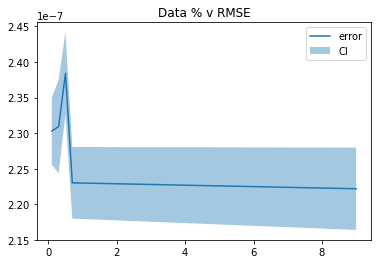

In [42]:
fig, ax = plt.subplots()
generate_metric_figure_from_values(percentages, errors, title="Data % v RMSE", ax=ax, label="error", ci=sme)

## Summary

We find that:
  - Occurrence as a representation factor for (state, action) pairs gives reasonable approximiate results.
  - The standard mean error for the estimate is small with as little as 10% of 43,663 transitions (each with two steps)